In [7]:
!pip install pytorch-lightning
!pip install optuna
!pip install wandb
!pip install optuna-integration[pytorch_lightning]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 8.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

# Path to your zip file in Google Drive
zip_path = '/content/drive/My Drive/archive.zip'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')


In [3]:
os.listdir('/content/data')

['seg_pred', 'seg_train', 'seg_test']

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchvision.models import resnet50, efficientnet_b0, ResNet50_Weights, EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import zipfile
import os


In [9]:
wandb.init(project="intel-image-classification")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations for the training and test datasets
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='/content/data/seg_train/seg_train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='/content/data/seg_test/seg_test', transform=test_transform)

# Create DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


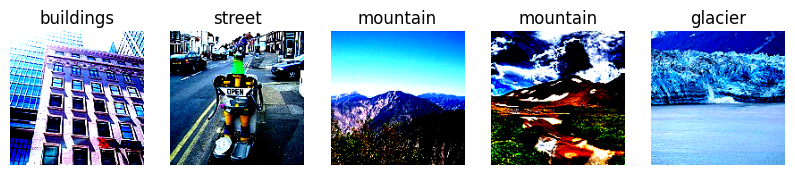

In [11]:
# prompt: show an example of train data in image

import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
dataiter = iter(train_dataloader)
images, labels = next(dataiter) # Changed dataiter.next() to next(dataiter)

# Show images
plt.figure(figsize=(10, 5))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
  plt.title(train_dataset.classes[labels[i]])
  plt.axis('off')
plt.show()

In [12]:
import torchvision.models as models
import torch.nn as nn

class ImageClassificationModel(pl.LightningModule):
    def __init__(self, num_classes, backbone="resnet50", learning_rate=1e-3):
        super(ImageClassificationModel, self).__init__()
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

        # Select backbone and configure output layer
        if backbone == "resnet50":
            self.backbone = models.resnet50(pretrained=True)
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        elif backbone == "efficientnet_b0":
            self.backbone = models.efficientnet_b0(pretrained=True)
            self.backbone.classifier[1] = nn.Linear(self.backbone.classifier[1].in_features, num_classes)
        else:
            raise ValueError("Invalid backbone name")

        # Freeze backbone layers except the output layer
        # Changed self.model to self.backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        # Changed self.model to self.backbone
        for param in (self.backbone.fc.parameters() if backbone == "resnet50" else self.backbone.classifier.parameters()):
            param.requires_grad = True

    def forward(self, x):
        # Changed self.model to self.backbone
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('train/loss', loss, on_step=True, prog_bar=True, on_epoch=True)
        self.log('train/acc', acc, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('val/loss', loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log('val/acc', acc, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # Changed self.parameters() to self.backbone.parameters() to optimize only the backbone's parameters
        optimizer = optim.Adam(self.backbone.parameters(), lr=self.learning_rate)
        return optimizer

    def configure_callbacks(self):
        checkpoint_callback = ModelCheckpoint(
            monitor='val/acc',
            dirpath='./checkpoints',
            filename='best_model',
            save_top_k=1,
            mode='max',
            verbose=True
        )
        return [checkpoint_callback]

In [13]:

# Optuna objective function
def objective(trial):
    backbone = trial.suggest_categorical("backbone", ["resnet50", "efficientnet_b0"])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    model = ImageClassificationModel(num_classes=6, backbone=backbone, learning_rate=learning_rate)

    # Initialize the Weights & Biases logger
    wandb_logger = WandbLogger(project="Intel Image Classification", log_model=True)

    # Trainer without pruning callback
    trainer = pl.Trainer(
        logger=wandb_logger,
        max_epochs=10,
        callbacks=[ModelCheckpoint(monitor='val/acc', mode='max', save_top_k=1)],
        enable_progress_bar=True
    )

    try:
        # Fit model
        trainer.fit(model, train_dataloader, val_dataloader)
    except KeyboardInterrupt:
        print("Training interrupted by user.")
        # Add any custom logic here, such as saving intermediate results
        return None  # or a default value

    # Get final validation accuracy
    val_acc = trainer.callback_metrics["val/acc"].item()
    return val_acc



In [14]:
# Wandb initialization
wandb.login()
wandb_logger = WandbLogger(log_model="all", project="IntelImageClassification", name='optuna_trial')


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [23]:
# Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-11-08 19:45:01,197] A new study created in memory with name: no-name-862770d7-1ccd-4d59-a42c-828ce950d652
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.89367 (best 0.89367), saving model to '/content/checkpoints/best_model-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.89367 (best 0.89367), saving model to '/content/checkpoints/best_model-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' reached 0.90133 (best 0.90133), saving model to '/content/checkpoints/best_model-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' reached 0.90133 (best 0.90133), saving model to '/content/checkpoints/best_model-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 19:52:28,977] Trial 0 finished with value: 0.8949999809265137 and parameters: {'backbone': 'resnet50', 'learning_rate': 0.001158428030337236}. Best is trial 0 with value: 0.8949999809265137.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.67833 (best 0.67833), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.67833 (best 0.67833), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' reached 0.79533 (best 0.79533), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' reached 0.79533 (best 0.79533), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' reached 0.83533 (best 0.83533), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' reached 0.83533 (best 0.83533), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' reached 0.84633 (best 0.84633), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' reached 0.84633 (best 0.84633), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' reached 0.85867 (best 0.85867), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' reached 0.85867 (best 0.85867), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' reached 0.86167 (best 0.86167), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' reached 0.86167 (best 0.86167), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' reached 0.86867 (best 0.86867), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' reached 0.86867 (best 0.86867), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' reached 0.86900 (best 0.86900), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' reached 0.86900 (best 0.86900), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' reached 0.87000 (best 0.87000), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' reached 0.87000 (best 0.87000), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' reached 0.87233 (best 0.87233), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' reached 0.87233 (best 0.87233), saving model to '/content/checkpoints/best_model-v2.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 19:59:56,697] Trial 1 finished with value: 0.8723333477973938 and parameters: {'backbone': 'resnet50', 'learning_rate': 1.3009090033911697e-05}. Best is trial 0 with value: 0.8949999809265137.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.86500 (best 0.86500), saving model to '/content/checkpoints/best_model-v3.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.86500 (best 0.86500), saving model to '/content/checkpoints/best_model-v3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' reached 0.86833 (best 0.86833), saving model to '/content/checkpoints/best_model-v3.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' reached 0.86833 (best 0.86833), saving model to '/content/checkpoints/best_model-v3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 20:05:06,017] Trial 2 finished with value: 0.8573333621025085 and parameters: {'backbone': 'efficientnet_b0', 'learning_rate': 0.003256106532151537}. Best is trial 0 with value: 0.8949999809265137.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing call

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.84933 (best 0.84933), saving model to '/content/checkpoints/best_model-v4.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.84933 (best 0.84933), saving model to '/content/checkpoints/best_model-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' reached 0.88967 (best 0.88967), saving model to '/content/checkpoints/best_model-v4.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' reached 0.88967 (best 0.88967), saving model to '/content/checkpoints/best_model-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' reached 0.89533 (best 0.89533), saving model to '/content/checkpoints/best_model-v4.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' reached 0.89533 (best 0.89533), saving model to '/content/checkpoints/best_model-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' reached 0.89800 (best 0.89800), saving model to '/content/checkpoints/best_model-v4.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' reached 0.89800 (best 0.89800), saving model to '/content/checkpoints/best_model-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 20:12:33,341] Trial 3 finished with value: 0.8836666941642761 and parameters: {'backbone': 'resnet50', 'learning_rate': 0.001886272875373413}. Best is trial 0 with value: 0.8949999809265137.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.51100 (best 0.51100), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.51100 (best 0.51100), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' reached 0.67167 (best 0.67167), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' reached 0.67167 (best 0.67167), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' reached 0.73967 (best 0.73967), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' reached 0.73967 (best 0.73967), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' reached 0.77067 (best 0.77067), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' reached 0.77067 (best 0.77067), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' reached 0.78933 (best 0.78933), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' reached 0.78933 (best 0.78933), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' reached 0.79467 (best 0.79467), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' reached 0.79467 (best 0.79467), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' reached 0.80867 (best 0.80867), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' reached 0.80867 (best 0.80867), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' reached 0.80933 (best 0.80933), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' reached 0.80933 (best 0.80933), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' reached 0.81967 (best 0.81967), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' reached 0.81967 (best 0.81967), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' reached 0.82033 (best 0.82033), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' reached 0.82033 (best 0.82033), saving model to '/content/checkpoints/best_model-v5.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 20:17:40,207] Trial 4 finished with value: 0.8203333616256714 and parameters: {'backbone': 'efficientnet_b0', 'learning_rate': 1.563486388640503e-05}. Best is trial 0 with value: 0.8949999809265137.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.89067 (best 0.89067), saving model to '/content/checkpoints/best_model-v6.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.89067 (best 0.89067), saving model to '/content/checkpoints/best_model-v6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' reached 0.89633 (best 0.89633), saving model to '/content/checkpoints/best_model-v6.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' reached 0.89633 (best 0.89633), saving model to '/content/checkpoints/best_model-v6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' reached 0.89700 (best 0.89700), saving model to '/content/checkpoints/best_model-v6.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' reached 0.89700 (best 0.89700), saving model to '/content/checkpoints/best_model-v6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' reached 0.89833 (best 0.89833), saving model to '/content/checkpoints/best_model-v6.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' reached 0.89833 (best 0.89833), saving model to '/content/checkpoints/best_model-v6.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 20:25:06,402] Trial 5 finished with value: 0.8983333110809326 and parameters: {'backbone': 'resnet50', 'learning_rate': 0.001141915919443594}. Best is trial 5 with value: 0.8983333110809326.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilit

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.86767 (best 0.86767), saving model to '/content/checkpoints/best_model-v7.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.86767 (best 0.86767), saving model to '/content/checkpoints/best_model-v7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' reached 0.87600 (best 0.87600), saving model to '/content/checkpoints/best_model-v7.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' reached 0.87600 (best 0.87600), saving model to '/content/checkpoints/best_model-v7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' reached 0.88333 (best 0.88333), saving model to '/content/checkpoints/best_model-v7.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' reached 0.88333 (best 0.88333), saving model to '/content/checkpoints/best_model-v7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' reached 0.88533 (best 0.88533), saving model to '/content/checkpoints/best_model-v7.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' reached 0.88533 (best 0.88533), saving model to '/content/checkpoints/best_model-v7.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 20:32:31,976] Trial 6 finished with value: 0.8853333592414856 and parameters: {'backbone': 'resnet50', 'learning_rate': 0.00670635566398417}. Best is trial 5 with value: 0.8983333110809326.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utiliti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.63133 (best 0.63133), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.63133 (best 0.63133), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' reached 0.78267 (best 0.78267), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' reached 0.78267 (best 0.78267), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' reached 0.81533 (best 0.81533), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' reached 0.81533 (best 0.81533), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' reached 0.84133 (best 0.84133), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' reached 0.84133 (best 0.84133), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' reached 0.85033 (best 0.85033), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' reached 0.85033 (best 0.85033), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' reached 0.85867 (best 0.85867), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' reached 0.85867 (best 0.85867), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' reached 0.86267 (best 0.86267), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' reached 0.86267 (best 0.86267), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' reached 0.86667 (best 0.86667), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' reached 0.86667 (best 0.86667), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' reached 0.87000 (best 0.87000), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' reached 0.87000 (best 0.87000), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' reached 0.87367 (best 0.87367), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' reached 0.87367 (best 0.87367), saving model to '/content/checkpoints/best_model-v8.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 20:39:56,222] Trial 7 finished with value: 0.8736666440963745 and parameters: {'backbone': 'resnet50', 'learning_rate': 1.1322835389946683e-05}. Best is trial 5 with value: 0.8983333110809326.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.util

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.84300 (best 0.84300), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.84300 (best 0.84300), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' reached 0.85600 (best 0.85600), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' reached 0.85600 (best 0.85600), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' reached 0.86267 (best 0.86267), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' reached 0.86267 (best 0.86267), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' reached 0.86700 (best 0.86700), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' reached 0.86700 (best 0.86700), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' reached 0.87133 (best 0.87133), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' reached 0.87133 (best 0.87133), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' reached 0.87667 (best 0.87667), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' reached 0.87667 (best 0.87667), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' reached 0.88033 (best 0.88033), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' reached 0.88033 (best 0.88033), saving model to '/content/checkpoints/best_model-v9.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 20:45:03,055] Trial 8 finished with value: 0.8803333044052124 and parameters: {'backbone': 'efficientnet_b0', 'learning_rate': 0.0003256445111461475}. Best is trial 5 with value: 0.8983333110809326.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 439: 'val/acc' reached 0.78233 (best 0.78233), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 439: 'val/acc' reached 0.78233 (best 0.78233), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 878: 'val/acc' reached 0.82200 (best 0.82200), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 878: 'val/acc' reached 0.82200 (best 0.82200), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1317: 'val/acc' reached 0.83367 (best 0.83367), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1317: 'val/acc' reached 0.83367 (best 0.83367), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1756: 'val/acc' reached 0.84033 (best 0.84033), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1756: 'val/acc' reached 0.84033 (best 0.84033), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2195: 'val/acc' reached 0.84267 (best 0.84267), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2195: 'val/acc' reached 0.84267 (best 0.84267), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2634: 'val/acc' reached 0.84433 (best 0.84433), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 2634: 'val/acc' reached 0.84433 (best 0.84433), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3073: 'val/acc' reached 0.85133 (best 0.85133), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3073: 'val/acc' reached 0.85133 (best 0.85133), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3512: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 3512: 'val/acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3951: 'val/acc' reached 0.85300 (best 0.85300), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 3951: 'val/acc' reached 0.85300 (best 0.85300), saving model to '/content/checkpoints/best_model-v10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 4390: 'val/acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 4390: 'val/acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-11-08 20:50:15,266] Trial 9 finished with value: 0.8529999852180481 and parameters: {'backbone': 'efficientnet_b0', 'learning_rate': 6.289788316547477e-05}. Best is trial 5 with value: 0.8983333110809326.


In [25]:
# Print the best trial parameters
best_trial = study.best_trial
print("Best Trial parameters:", best_trial.params)
print("Best Validation Loss:", best_trial.value)

Best Trial parameters: {'backbone': 'resnet50', 'learning_rate': 0.001141915919443594}
Best Validation Loss: 0.8983333110809326


In [26]:
# Use the best model (based on the best learning rate found)
best_trial = study.best_trial  # Get the best trial from the study
best_learning_rate = best_trial.params['learning_rate']
best_model = ImageClassificationModel(num_classes=6, backbone=best_trial.params['backbone'], learning_rate=best_learning_rate)

In [28]:
# Prediction DataLoader
pred_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Assuming seg_pred directory has subfolders for each class
pred_dataset = datasets.ImageFolder(root='/content/data/seg_pred', transform=pred_transform)
pred_loader = DataLoader(pred_dataset, batch_size=32, shuffle=False)

In [1]:
# Load the best model
checkpoint_path = './checkpoints/best_model.ckpt'
best_model = ImageClassificationModel.load_from_checkpoint(checkpoint_path, num_classes=6, learning_rate=best_learning_rate)

# Use the best model to make predictions on seg_pred
best_model.eval()
best_model.to(images.device)

# Prediction loop
predictions = []
filenames = []

with torch.no_grad():
    for images, filenames_batch in pred_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        filenames.extend(filenames_batch)

# Print or save predictions
print("Predictions: ", predictions)
print("Filenames: ", filenames)


NameError: name 'ImageClassificationModel' is not defined

In [2]:
# Optionally: Save predictions to a CSV
import pandas as pd
pred_df = pd.DataFrame({'filename': filenames, 'prediction': predictions})
pred_df.to_csv('predictions.csv', index=False)

NameError: name 'filenames' is not defined